In [1]:
from HeaderP import *

In [87]:
df = readfits('drive-download-20230516T145408Z-001/run753.01000stars.fits')

In [88]:
df = df.astype('float64')


In [92]:
df['R'] = np.sqrt(df.x**2+df.y**2)
df['Rb'] = np.sqrt(df.x_form**2+df.y_form**2)
df['age'] = 10-df['tform']
data['R_bir'] = data['Rb']
data = df

Text(0, 0.5, '[α/Fe]')

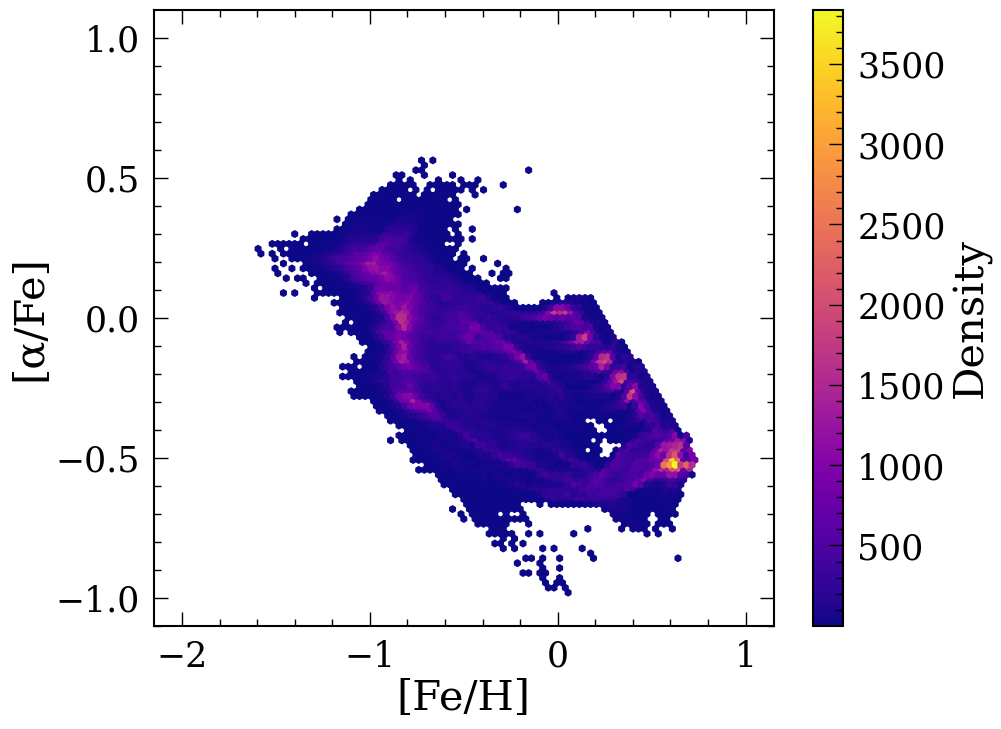

In [191]:
plt.figure(figsize=(10,8))
plt.hexbin(data['feh'], data['ofe'], extent=(-2,1,-1,1), cmap='plasma',
          mincnt=1)

cb = plt.colorbar()
cb.set_label('Density')
plt.xlabel('[Fe/H]')
plt.ylabel('[α/Fe]')

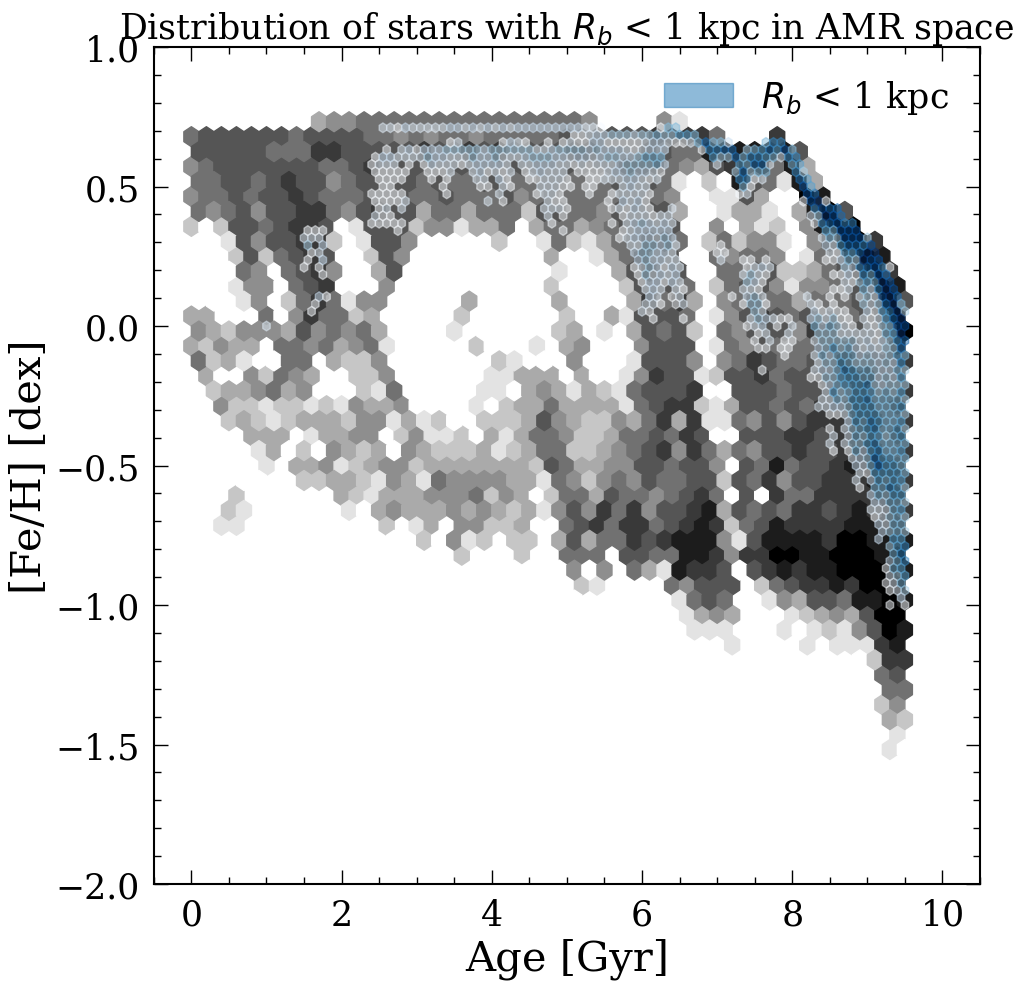

In [192]:

plt.figure()
m = (data['R']<100)
plt.hexbin(data['age'][m], data['feh'][m], 
          extent=(0,10,-2,1),mincnt=1,
           gridsize=50,cmap=plt.get_cmap('binary',10),
          bins='log')

m = (data['R_bir']<1)
plt.hexbin(data['age'][m], data['feh'][m], 
           cmap=plt.get_cmap('Blues',10), mincnt=50,
          extent=(0,10,-2,1),bins='log',label='$R_b$ < 1 kpc',
          alpha=0.5)
plt.ylim([-2,1])

plt.legend()
plt.xlabel('Age [Gyr]')
plt.ylabel('[Fe/H] [dex]')
plt.title('Distribution of stars with $R_b$ < 1 kpc in AMR space', fontsize=25)
plt.tight_layout()

Text(0, 0.5, '[Fe/H] [dex]')

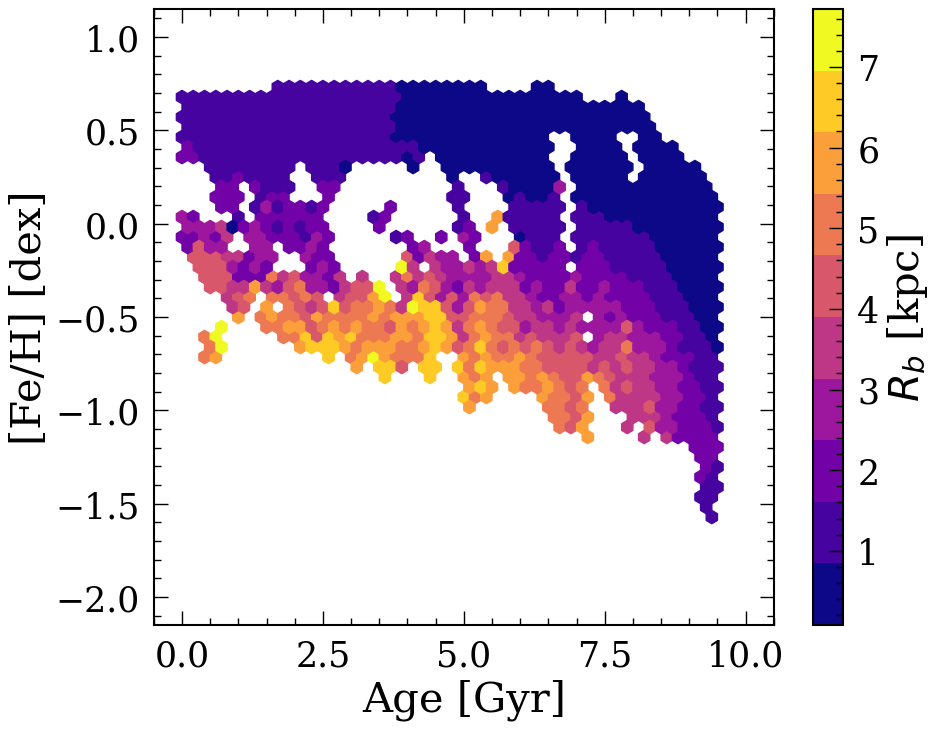

In [193]:

plt.figure(figsize=(10,8))
plt.hexbin(data['age'], data['feh'], C=data['R_bir'],
          extent=(0,10,-2,1),mincnt=1,
           gridsize=50,cmap=plt.get_cmap('plasma',10))

cb = plt.colorbar()
cb.set_label('$R_b$ [kpc]')

plt.xlabel('Age [Gyr]')
plt.ylabel('[Fe/H] [dex]')


100%|███████████████████████████████████████████| 11/11 [00:16<00:00,  1.53s/it]


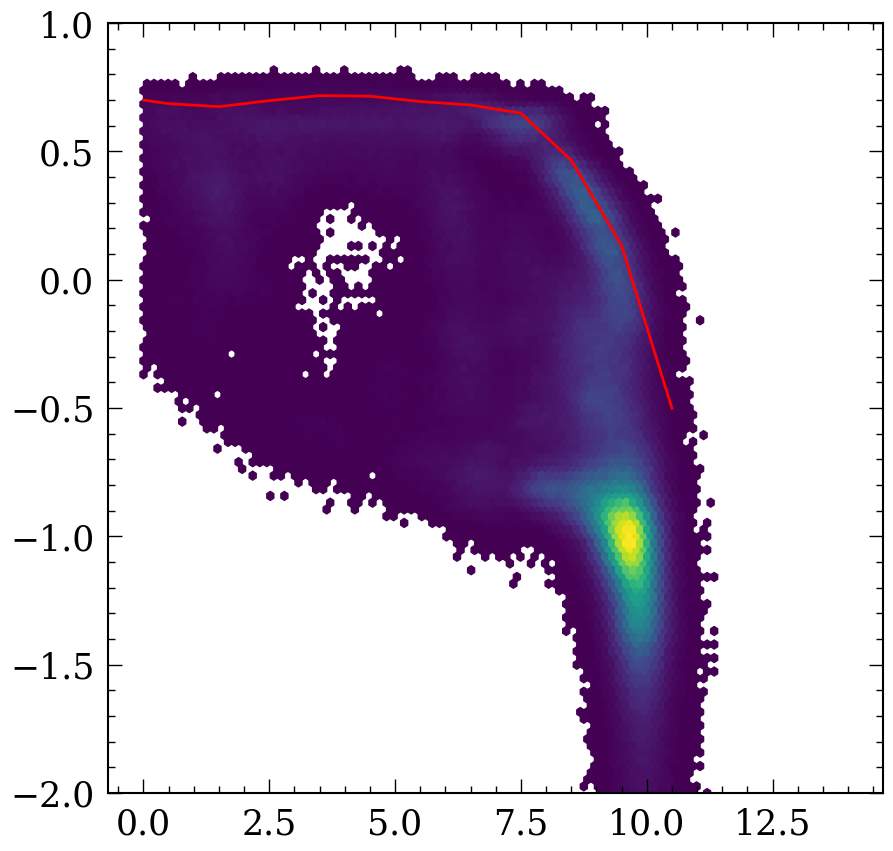

In [103]:
m = (data['R']<4)

allages = data['age'].values
allfehs = data['feh'].values
allofes = data['ofe'].values

data['age_new'] = [np.random.normal(i, 0.32, 1) for i in allages]
data['feh_new'] = [np.random.normal(i, 0.03, 1) for i in allfehs]
data['ofe_new'] = [np.random.normal(i, 0.03, 1) for i in allofes]


data_in = (data[(data['R']<4)].reset_index(drop=True))[['age_new','feh_new']].reset_index(drop=True)
agebin = np.linspace(0,11,12)
feh0 = np.zeros(len(agebin))

for i in trange(len(agebin)-1):
    m2 = (data_in['age_new']>agebin[i])&(data_in['age_new']<agebin[i+1])
    feh0[i+1] = np.percentile(data_in['feh_new'][m2], 95)

plt.hexbin(data_in['age_new'], data_in['feh_new'], extent=(0,14,-2,1),
          mincnt=1)

#feh0[np.append([0], agebin[1:]/2+agebin[:-1]/2)>2] = feh0[np.append([0], agebin[1:]/2+agebin[:-1]/2)>2]+0.1
#feh0 = feh0+0.1
feh0[0] = 0.7
#feh0[0] = 0.35

#feh0

plt.ylim([-2,1])
plt.plot(np.append([0], agebin[1:]/2+agebin[:-1]/2), feh0, 'r-')

In [104]:
def getRb(age, feh, func_m, func_b, fehoffset=0):
    """slopefeh = pd.read_csv('g2.79e12_fehscatter_simdata_inf.csv')
    
    func_m = interp1d(slopefeh['age'].values, 
                      slopefeh['sloperb_inf'].values,
                     kind='linear')
    
    func_m = interp1d(slopefeh['age'].values, 
                      slopefeh['slopes_rbir'].values,
                     kind='linear')
    
    func_b = interp1d(np.append([0], agebin[1:]/2+agebin[:-1]/2), feh0,
                     kind='linear')"""
    
    Rb = np.zeros(len(age))
    for i in trange(len(age)):
        try:
            m = func_m(age[i])
            b = func_b(age[i])
            Rb[i] = (feh[i]-b)/m
        except:
            Rb[i] = np.nan
    return Rb

In [105]:
def monoage_line(feh,r,age,agebin=np.linspace(0,14,8),
                feherr=[],xlims=[0,25],checkplt=True):
    colors = getcolor(range(len(agebin)+1))
    slopes = np.zeros(len(agebin)-1)
    fehscatter = np.zeros(len(agebin)-1)
    
    for i in trange(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        if sum(m)==0:
            fehscatter[i] = np.nan
            continue
        r_sing, feh_sing = zip(*sorted(zip(r[m], feh[m])))
        r_sing, feh_sing = np.array(r_sing, dtype=float), np.array(feh_sing, dtype=float)
            
        m2 = (r_sing>xlims[0])&(r_sing<xlims[1])
        if sum(m2)==0:
            fehscatter[i] = np.nan
            continue
        #feh_sing_fit, r_sing_fit = zip(*sorted(zip(feh_sing[m2], r_sing[m2])))
        #r_sing_fit, feh_sing_fit = np.array(r_sing_fit), np.array(feh_sing_fit)
        #feh_sing_fit, r_sing_fit = movingMed_time(feh_sing_fit, r_sing_fit, 0.1, 0.01)
        #r_sing_fit, feh_sing_fit = np.array(r_sing_fit), np.array(feh_sing_fit)
        p = fitpoints(r_sing[m2], feh_sing[m2]) 
        #p = fitpoints(r_sing_fit, feh_sing_fit) 
        slopes[i] = p[1]

        fehscatter[i] = np.std(feh_sing[m2]-p(r_sing[m2]))
        if len(feherr)>0:
            fehscatter[i] = np.sqrt(fehscatter[i]**2-np.mean(feherr[m][m2])**2)
            #print(np.std(feh_sing[m2]-p(r_sing[m2])))
        if checkplt:
            plt.figure(figsize=(8,8))
            plt.hexbin(r_sing[m2], feh_sing[m2],extent=(0,10,-2,0.5), bins='log',
                      cmap='binary')
            plt.plot(r_sing[m2], p(r_sing[m2]), 'k-',
                    label='%.2f Rb+%.2f'%(p[1],p[0]))
            #plt.plot([0,15], [np.percentile(feh_sing[m2],95),np.percentile(feh_sing[m2],95)],'b-')
            #plt.plot([0,15], [np.percentile(feh_sing[m2],5),np.percentile(feh_sing[m2],5)],'b-')
            #plt.plot([np.percentile(r_sing[m2],95),np.percentile(r_sing[m2],95)], [-3,0.5],'b-')
            #plt.plot([np.percentile(r_sing[m2],5),np.percentile(r_sing[m2],5)], [-3,0.5],'b-')
            plt.xlim([0,10])
            plt.ylim([-2,0.5])
            plt.xlabel('Rb [kpc]')
            plt.ylabel('[Fe/H]')
            plt.title('%.2f Gyr - %.2f Gyr'%(agebin[i],agebin[i+1]),
                     fontsize=25)
            plt.legend()
            plt.savefig(str(len(agebin)-1-i)+'.png')

    return (agebin[:-1]+agebin[1:])/2, slopes, fehscatter

In [106]:
def calcvel(vx, vy, x, y, v0):
    R = np.sqrt(x**2+y**2)
    vr = (x * vx + y * vy)/R
    vphi = (x * vy - y * vx)/R
    ecc = np.sqrt(vr**2 + 2.*(vphi-v0)**2)/(np.sqrt(2.)*v0)
    
    return vr, vphi, ecc

 95%|████████████████████████████████████████▉  | 20/21 [00:25<00:01,  1.46s/it]/var/folders/w0/h14c78gj4rs91wsbcjh87y2m0000gn/T/ipykernel_78320/1632371629.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(8,8))
 95%|████████████████████████████████████████▉  | 20/21 [00:21<00:01,  1.24s/it]


 10%|████▏                                       | 2/21 [00:02<00:19,  1.00s/it]


100%|███████████████████████████████████████████| 10/10 [04:18<00:00, 25.84s/it]


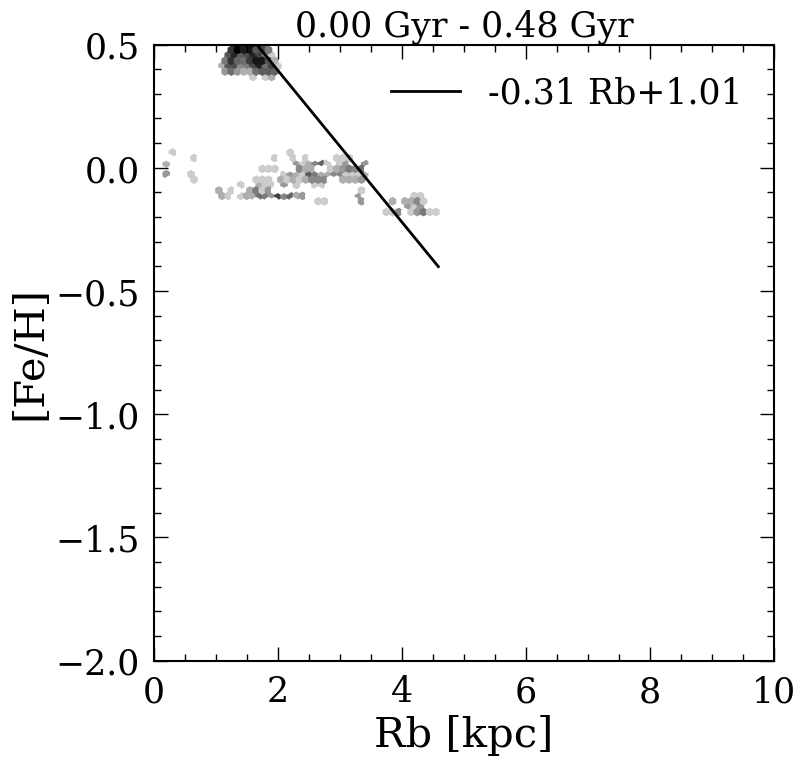

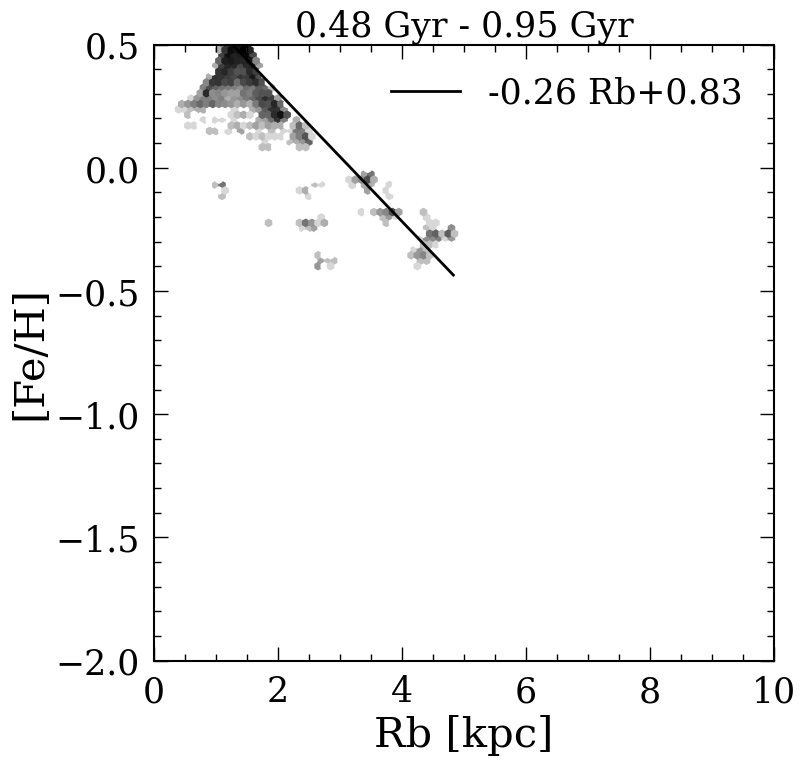

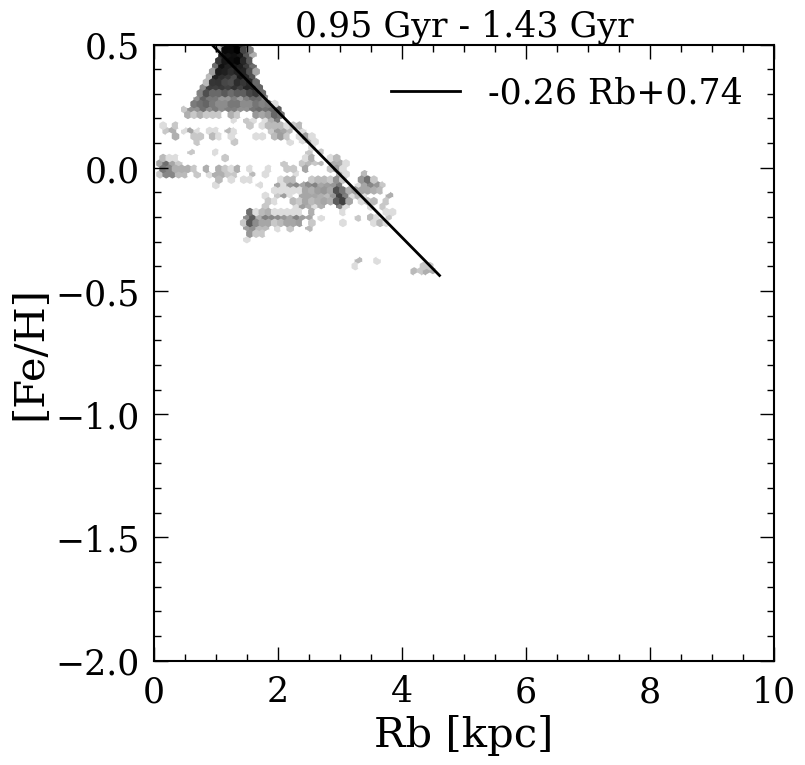

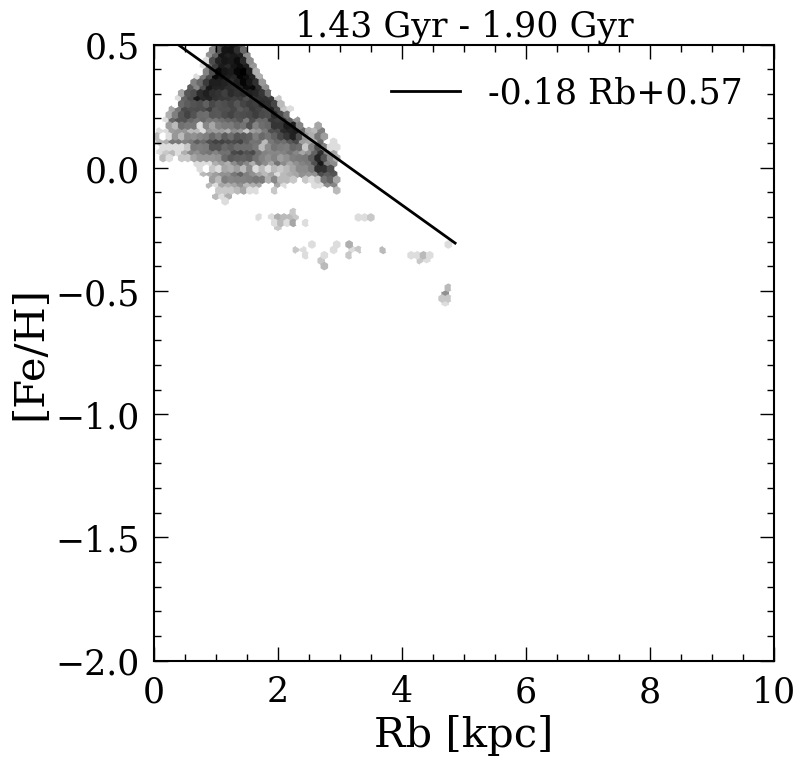

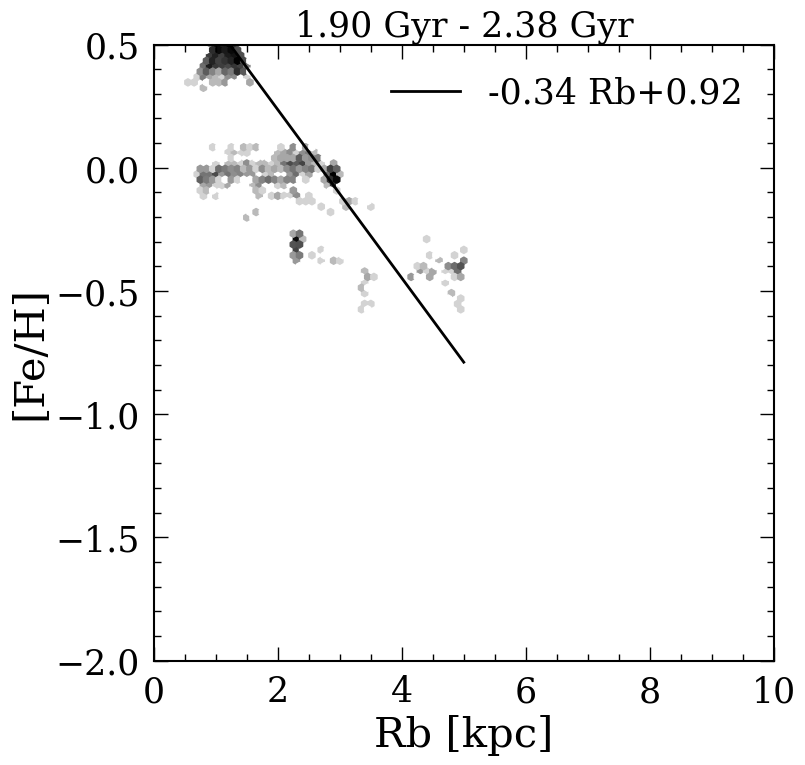

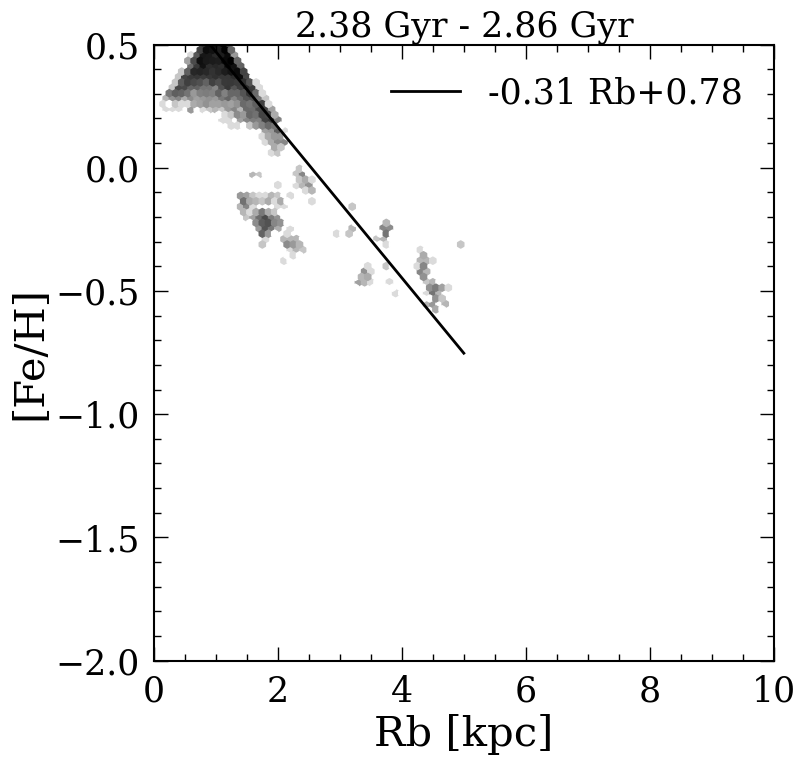

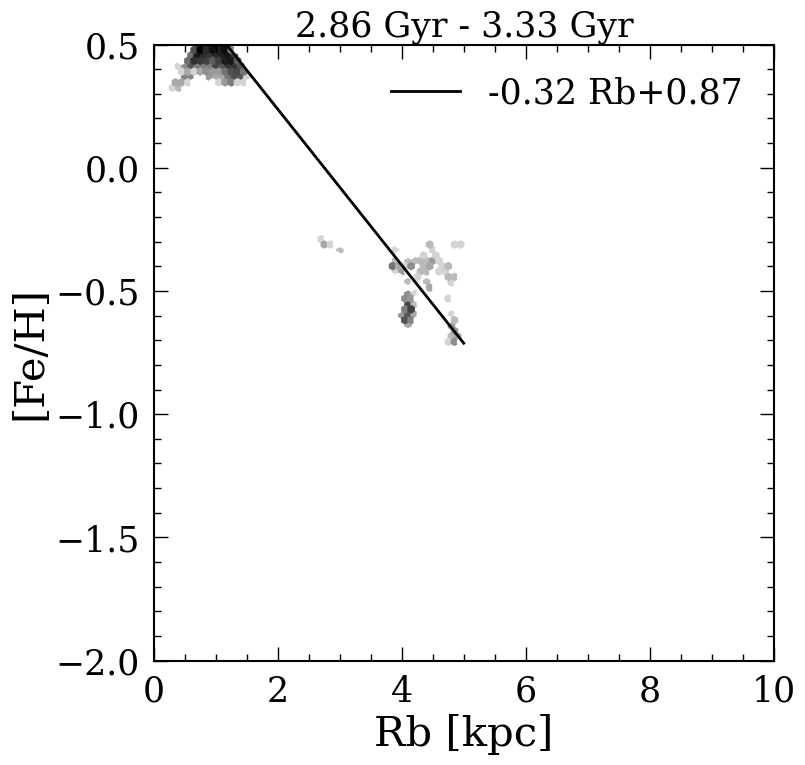

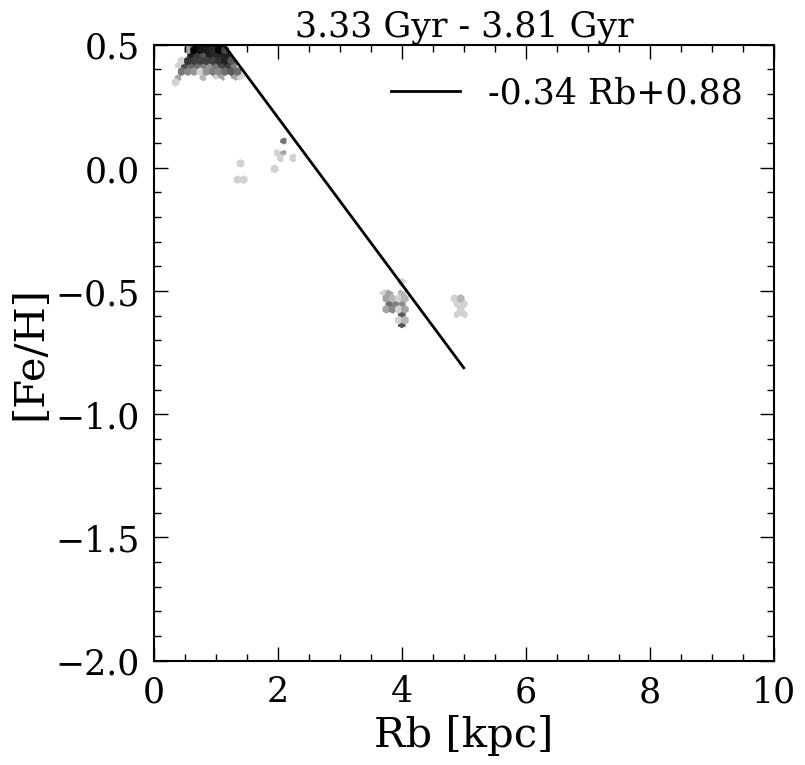

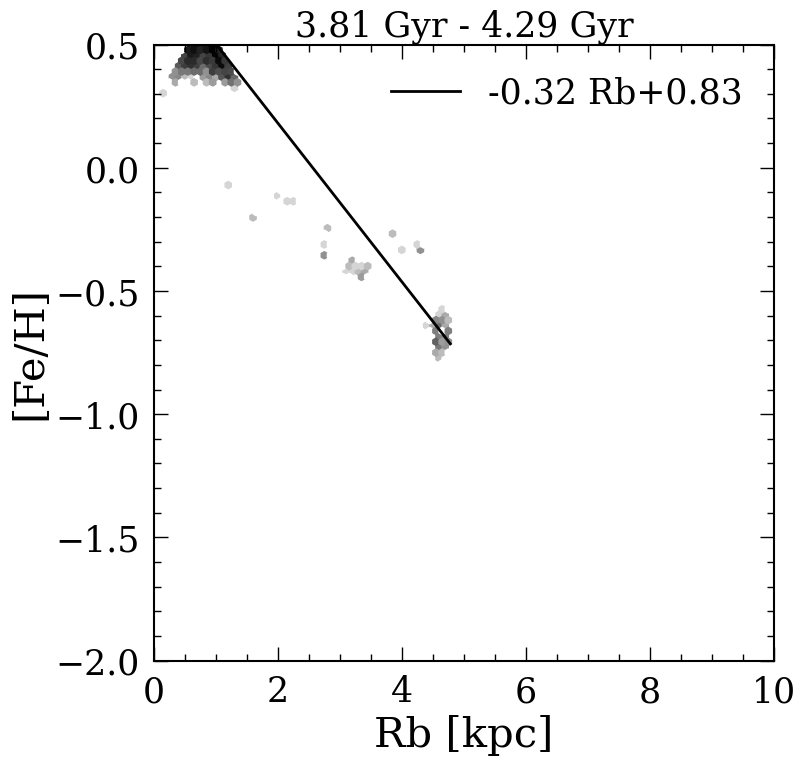

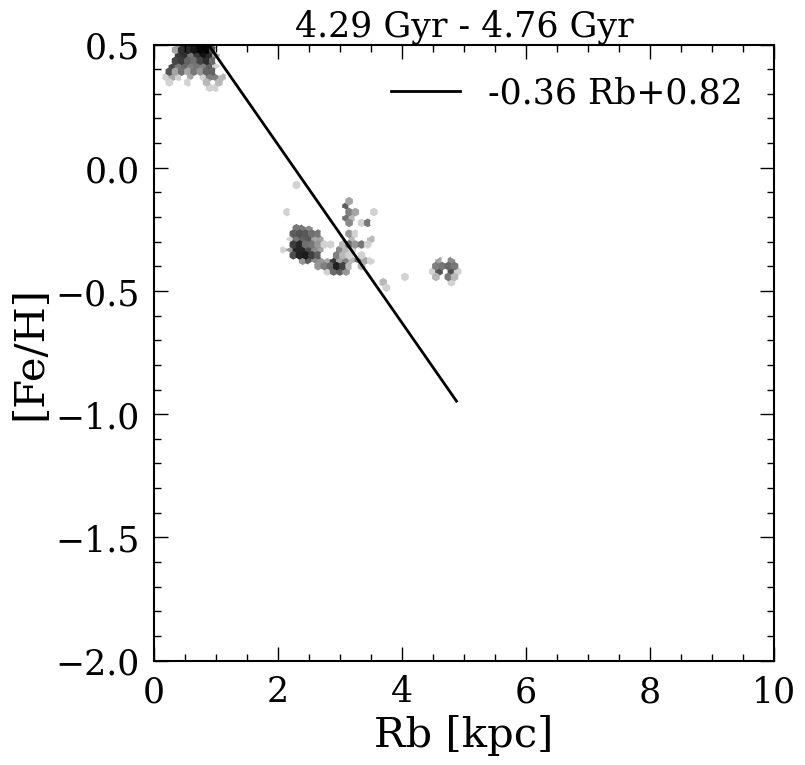

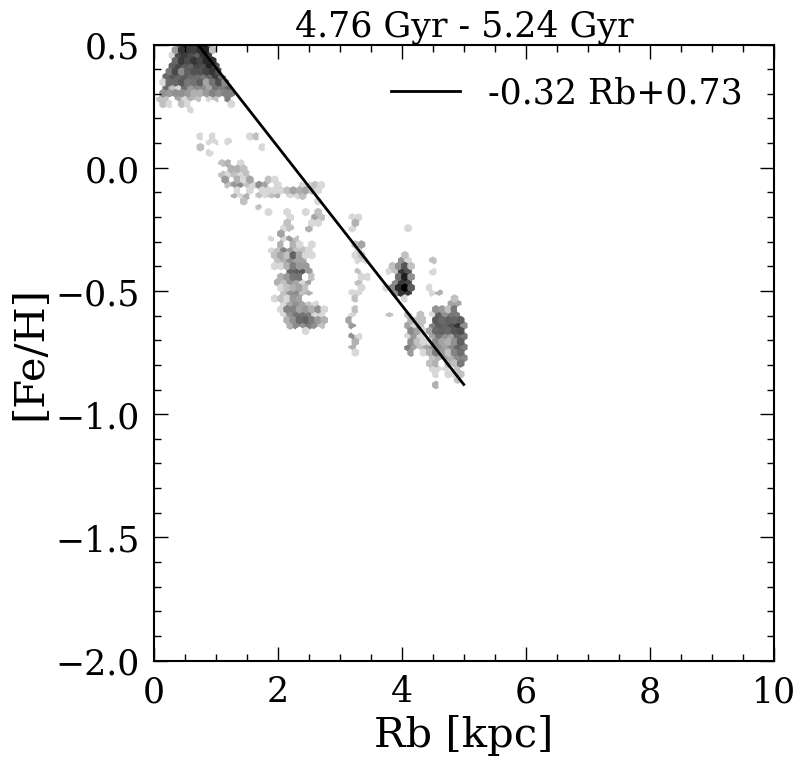

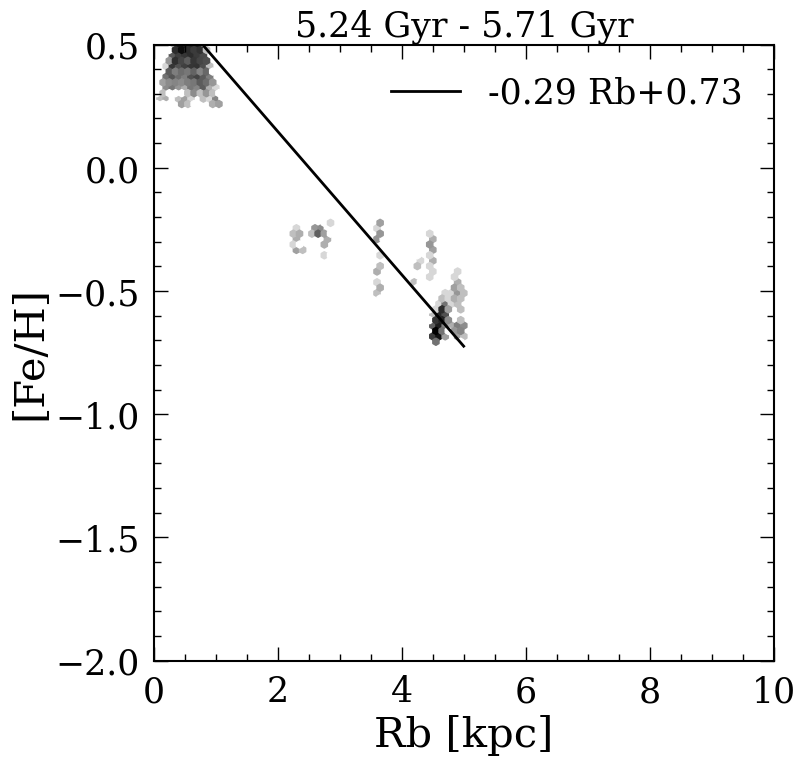

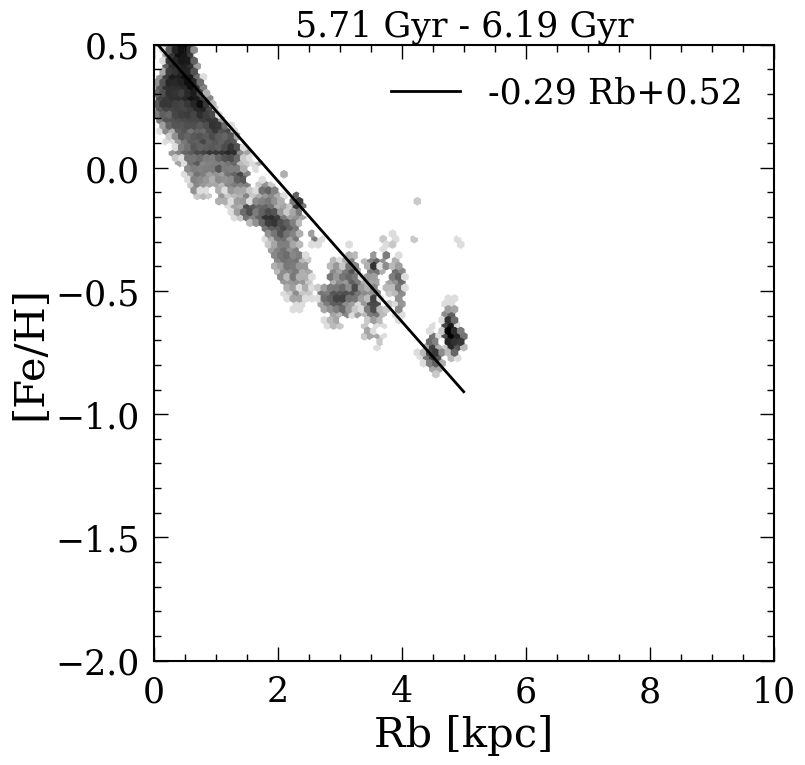

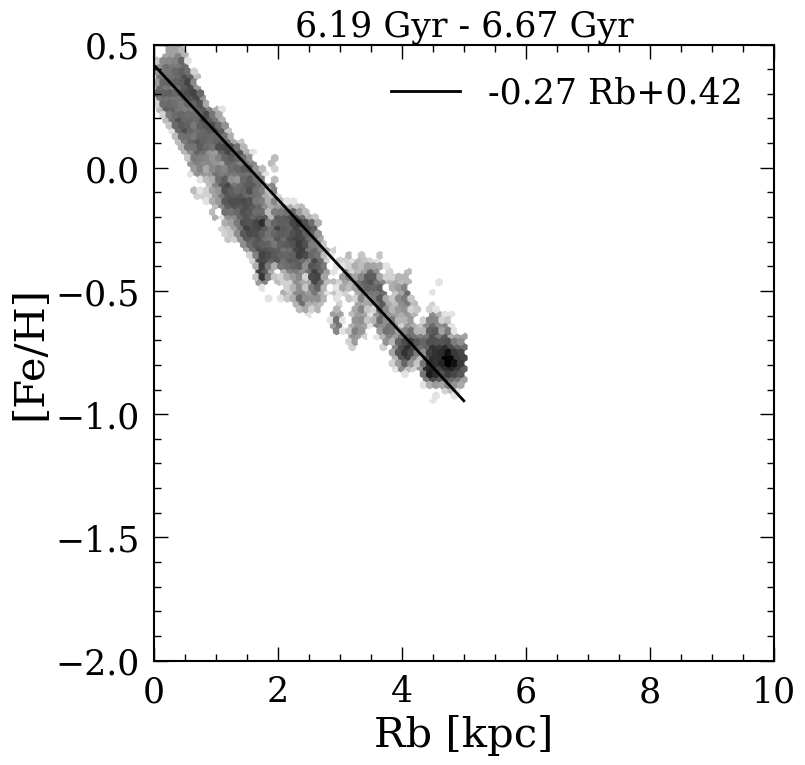

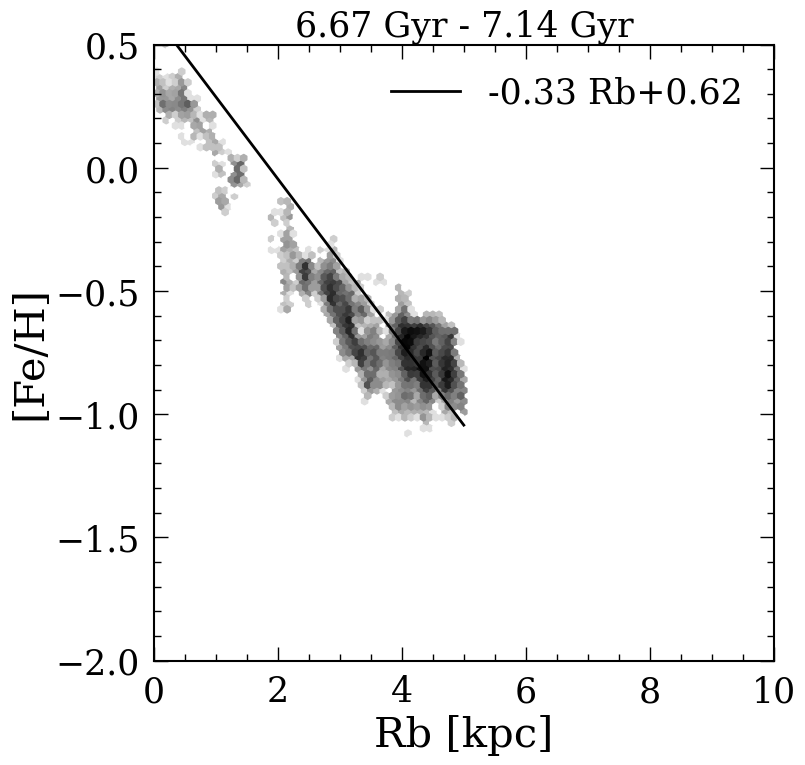

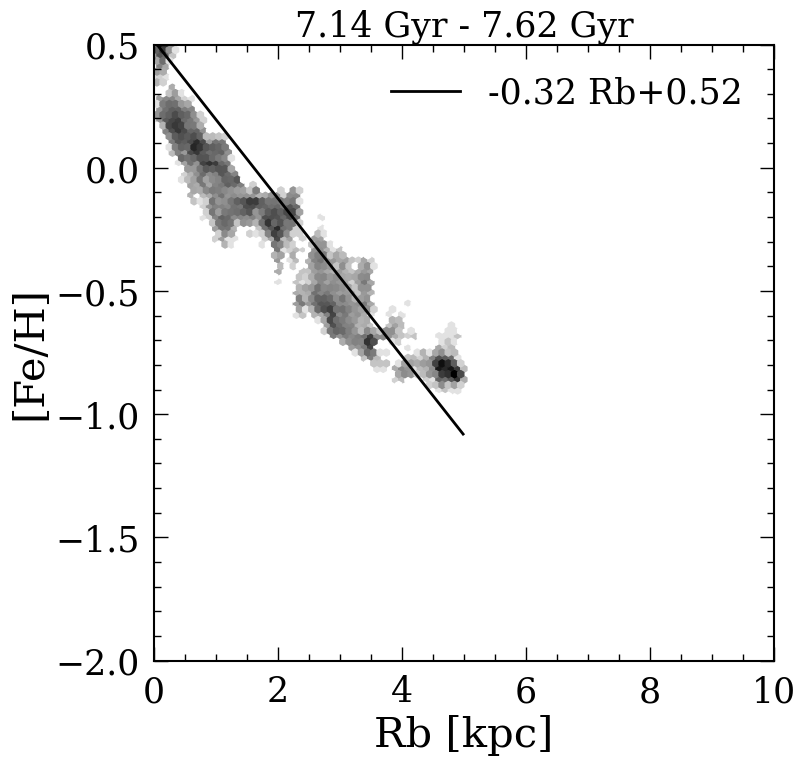

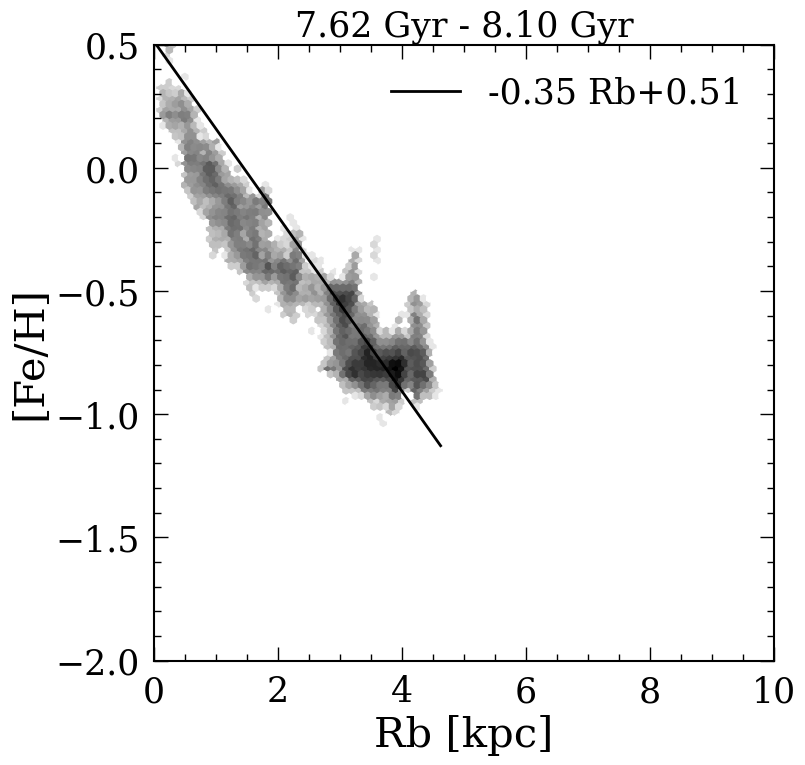

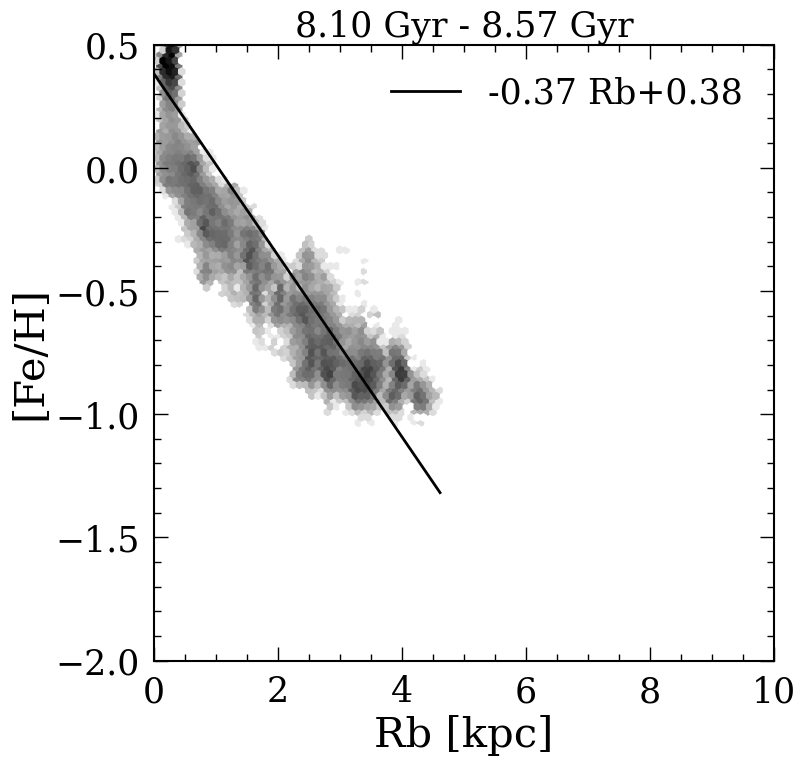

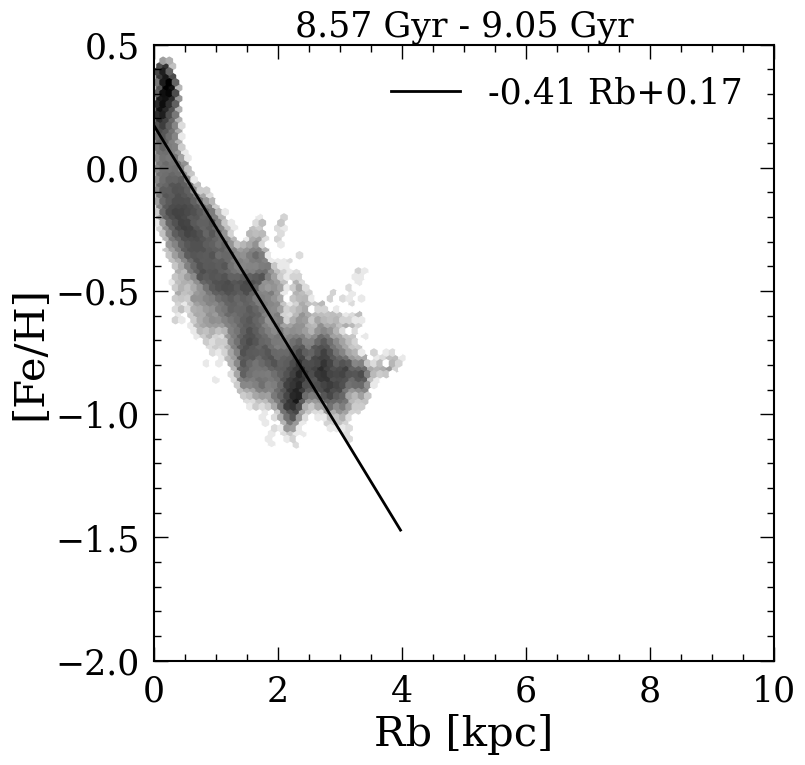

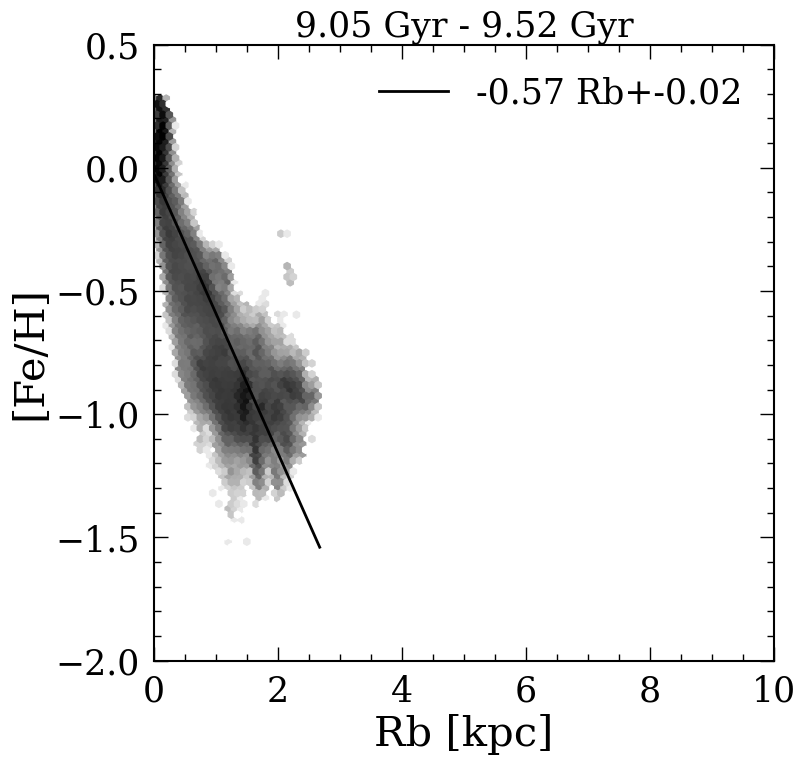

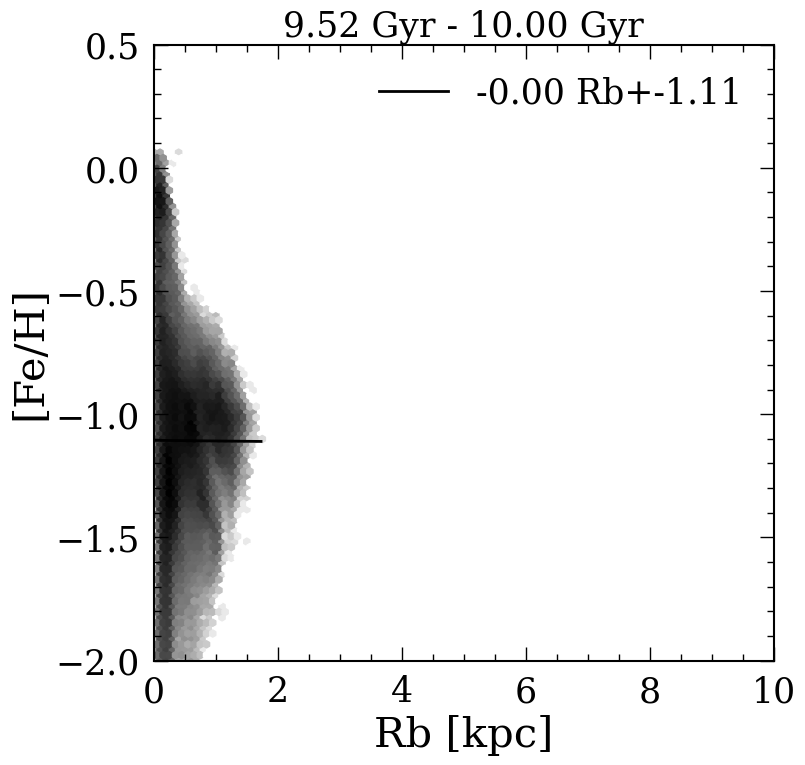

<Figure size 2000x800 with 0 Axes>

<Figure size 2000x800 with 0 Axes>

<Figure size 2000x800 with 0 Axes>

<Figure size 2000x800 with 0 Axes>

<Figure size 2000x800 with 0 Axes>

<Figure size 2000x800 with 0 Axes>

<Figure size 2000x800 with 0 Axes>

<Figure size 2000x800 with 0 Axes>

<Figure size 2000x800 with 0 Axes>

<Figure size 2000x800 with 0 Axes>

In [137]:
def monoage_line_range(feh,r,age,agebin=np.linspace(0,14,8),xlims=[6,12],ylims=[-1.5,0.5],
                feherr=[],plotlegend=True,rrange_feh=[7,10]):
    colors = getcolor(range(len(agebin)+1))
    slopes = np.zeros(len(agebin)-1)
    fehscatter = np.zeros(len(agebin)-1)
    
    plt.figure(figsize=(20,8))
    for i in range(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        if sum(m)==0:
            fehscatter[i] = np.nan
            continue
        r_sing, feh_sing = zip(*sorted(zip(r[m], feh[m])))
        r_sing, feh_sing = np.array(r_sing, dtype=float), np.array(feh_sing, dtype=float)
        
        m2 = (r_sing>xlims[0])&(r_sing<xlims[1])
        if sum(m2)==0:
            fehscatter[i] = np.nan
            continue
        fehscatter[i] = np.percentile(feh_sing[m2],95)-np.percentile(feh_sing[m2],5)
        if len(feherr)>0:
            fehscatter[i] = np.sqrt(fehscatter[i]**2-np.mean(feherr[m][m2])**2)
            #print(np.std(feh_sing[m2]-p(r_sing[m2])))
    return (agebin[:-1]+agebin[1:])/2, slopes, fehscatter


data_calc = data.reset_index(drop=True)

testsize=10

age_calc = np.linspace(0,10,22)
slopes_arr = np.zeros((len(age_calc)-1, testsize))
fehscatter_arr = np.zeros((len(age_calc)-1, testsize))

ages, slopes_rbir, fehscatter_rbir = monoage_line(data['feh'].values, 
                                        data['R_bir'].values, 
                                        data['age'].values,
                                        agebin=age_calc,
                                                 xlims=[0,5])

"""ages, slopes_rbir, fehscatter_rbir_5 = monoage_line(data['feh'].values[m], 
                                        data['Rg_b'].values[m], 
                                        data['age'].values[m],
                                        agebin=age_calc,
                                                 xlims=[0,15])"""

for i in trange(10):
    data_calc['age_new'] = [np.random.normal(i, 0.5) for i in data_calc['age']]
    #data_calc['R_new'] = data_calc['R']
    data_calc['feh_new'] = [np.random.normal(i, 0.03) for i in data_calc['feh']]
    ages, slopes_arr[:,i], fehscatter_arr[:,i] = monoage_line_range(data_calc['feh_new'].values, 
                                            data_calc['R'].values, 
                                            data_calc['age_new'].values,
                                            agebin=age_calc,
                                            xlims=[0,10],plotlegend=False)

In [141]:
slopes = [np.mean(slopes_arr[i,:]) for i in range(len(age_calc)-1)]
slopes_err = [np.std(slopes_arr[i,:]) for i in range(len(age_calc)-1)]

fehscatter = [np.mean(fehscatter_arr[i,:]) for i in range(len(age_calc)-1)]
fehscatter_err = [np.std(fehscatter_arr[i,:]) for i in range(len(age_calc)-1)]

In [142]:
pd.DataFrame(np.array((ages, slopes, fehscatter, slopes_rbir, fehscatter_rbir)).T,
            columns=['age', 'slopes', 'fehscatter', 'slopes_rbir', 
                     'fehscatter_rbir']).to_csv('753_fehscatter_simdata.csv', 
                                                index=False)

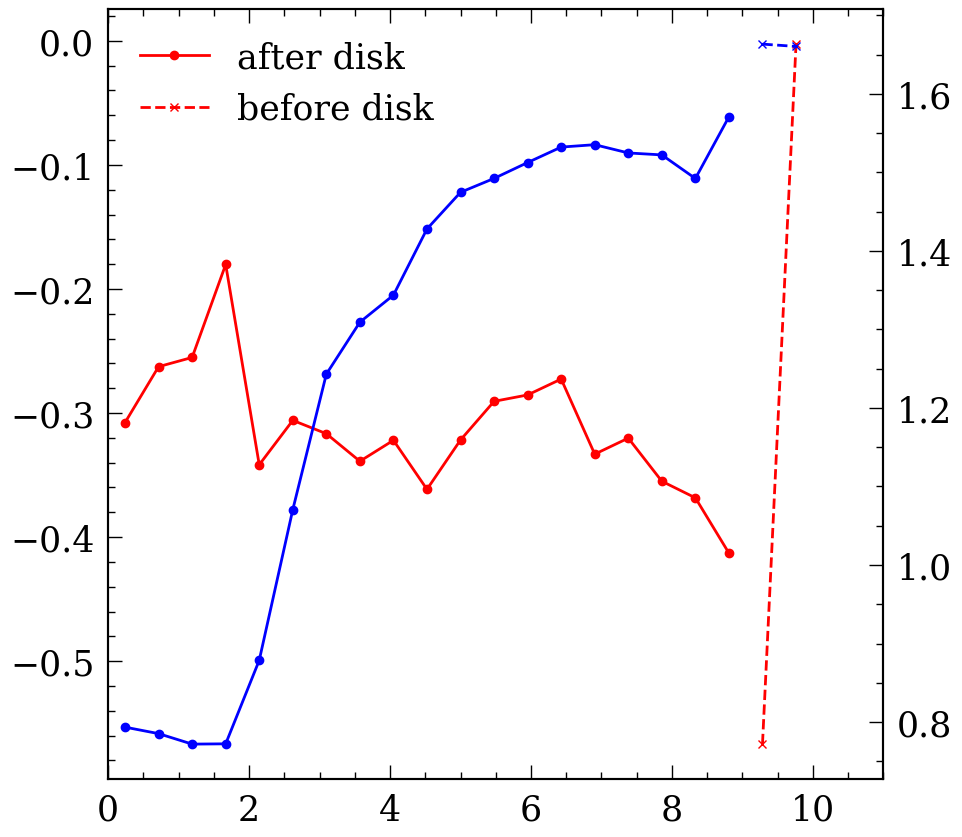

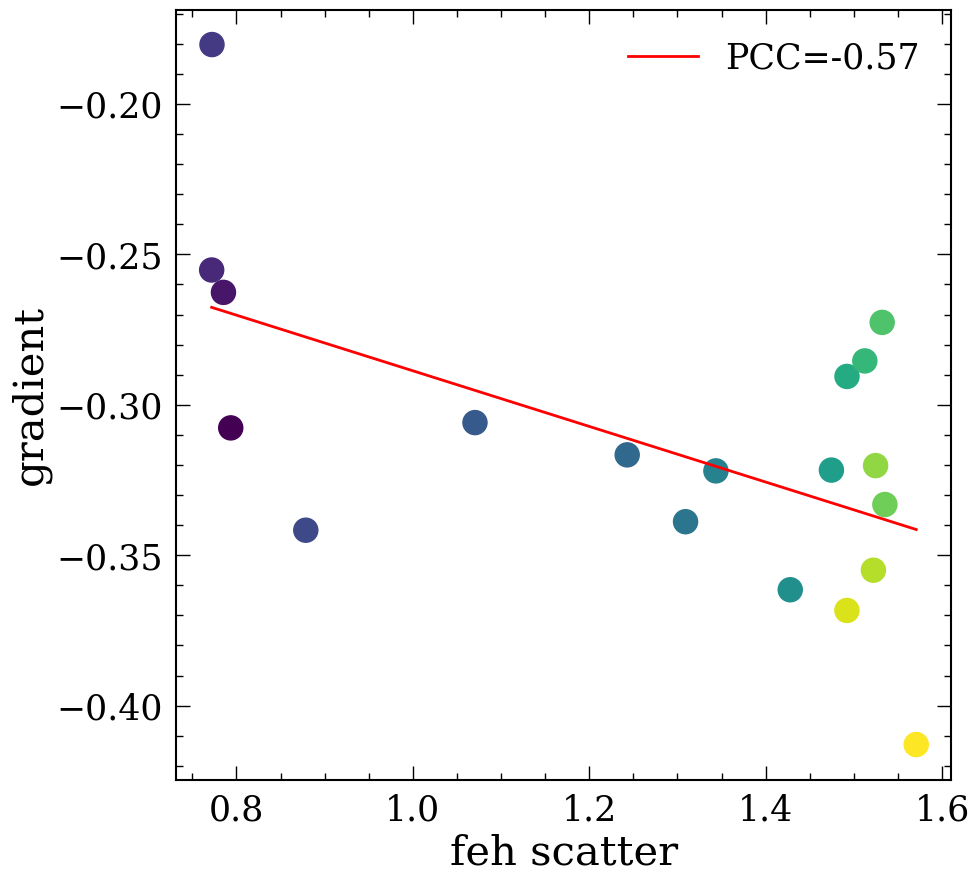

In [185]:
disktime = 9
m = (ages<disktime)
plt.plot(ages[m], slopes_rbir[m], 'r-o',label='after disk')
plt.plot(ages[~m], slopes_rbir[~m], 'r--x',label='before disk')
plt.legend()
plt.twinx()
plt.plot(ages[m], np.array(fehscatter)[m], 'b-o')
plt.plot(ages[~m], np.array(fehscatter)[~m], 'b--x')
plt.xlim([0,11])

plt.figure()
plt.scatter(np.array(fehscatter)[m], np.array(slopes_rbir)[m], c=np.array(ages)[m], s=300)
p_fit = fitpoints(np.array(fehscatter)[m], np.array(slopes_rbir)[m])
import scipy
plt.plot([min(np.array(fehscatter)[m]), max(np.array(fehscatter)[m])], 
         p_fit([min(np.array(fehscatter)[m]), max(np.array(fehscatter)[m])]),'r-',
        label="PCC=%.2f"%(scipy.stats.pearsonr(np.array(fehscatter)[m], np.array(slopes_rbir)[m])[0]))
plt.xlabel('feh scatter')
plt.ylabel('gradient')
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(-1.0, 1.0)

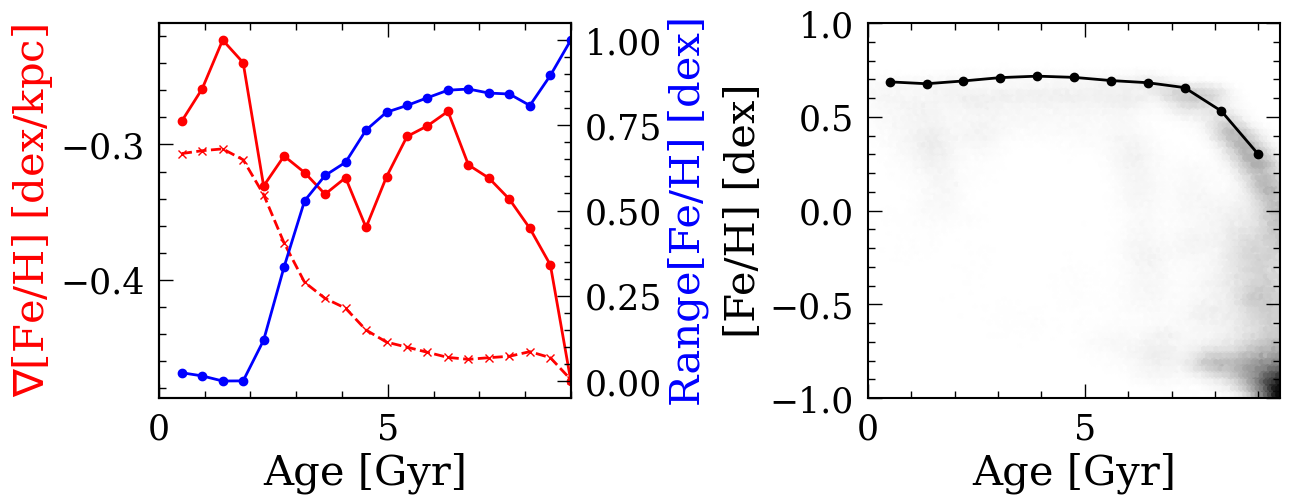

In [202]:
slopefeh = pd.read_csv('753_fehscatter_simdata.csv')

slopefeh = slopefeh.loc[slopefeh['age']<=disktime+0.5]
x = slopefeh['slopes_rbir']

slopefeh = slopefeh.dropna(subset=['fehscatter'])
slopefeh['fehscatter'] = (slopefeh['fehscatter']-min(slopefeh['fehscatter']))/(max(slopefeh['fehscatter'])-min(slopefeh['fehscatter']))
p = fitpoints(slopefeh['fehscatter'], x)
multfac = 1.5
realsope = (slopefeh['slopes_rbir'].iloc[0])
slopefeh['sloperb_inf'] = (p(slopefeh['fehscatter']))*multfac-(p(slopefeh['fehscatter'].iloc[0]))*multfac+realsope

func_m_true = interp1d(slopefeh['age'].values, 
                      slopefeh['slopes_rbir'].values,
                     kind='linear')

func_m = interp1d(slopefeh['age'].values, 
                      slopefeh['sloperb_inf'].values,
                     kind='linear')

func_b = interp1d(np.append([0], agebin[1:]/2+agebin[:-1]/2), feh0,
                     kind='linear')


plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.plot(np.linspace(0.5,disktime,len(slopefeh['fehscatter'])), func_m(np.linspace(0.5,disktime,len(slopefeh['fehscatter']))), 'r--x',
        label='Inferred')
plt.plot(np.linspace(0.5,disktime,len(slopefeh['fehscatter'])), func_m_true(np.linspace(0.5,disktime,len(slopefeh['fehscatter']))), 'r-o',
        label='True')
plt.xlabel('Age [Gyr]')
plt.ylabel('$\\nabla$[Fe/H] [dex/kpc]', color='red')
plt.xlim([0,disktime])
plt.twinx()
plt.plot(np.linspace(0.5,disktime,len(slopefeh['fehscatter'])), slopefeh['fehscatter'], 'b-o',
        label='True')
plt.ylabel('Range[Fe/H] [dex]', color='blue')



plt.subplot(1,2,2)
plt.hexbin(data_in['age_new'], data_in['feh_new'], extent=(0,disktime+0.5,-1,1),
          mincnt=1, cmap='binary')
plt.plot(np.linspace(0.5,disktime,11), func_b(np.linspace(0.5,disktime,11)), 'k-o')
plt.xlabel('Age [Gyr]')
plt.ylabel('[Fe/H] [dex]')
plt.legend()
plt.tight_layout()

plt.xlim([0,disktime+0.5])
plt.ylim([-1,1])


In [203]:
data = data.loc[data['age']<disktime]
data['Rb_inf_new'] = getRb(data['age_new'].values, data['feh_new'].values, func_m, func_b)

100%|████████████████████████████████| 444181/444181 [00:05<00:00, 76888.07it/s]


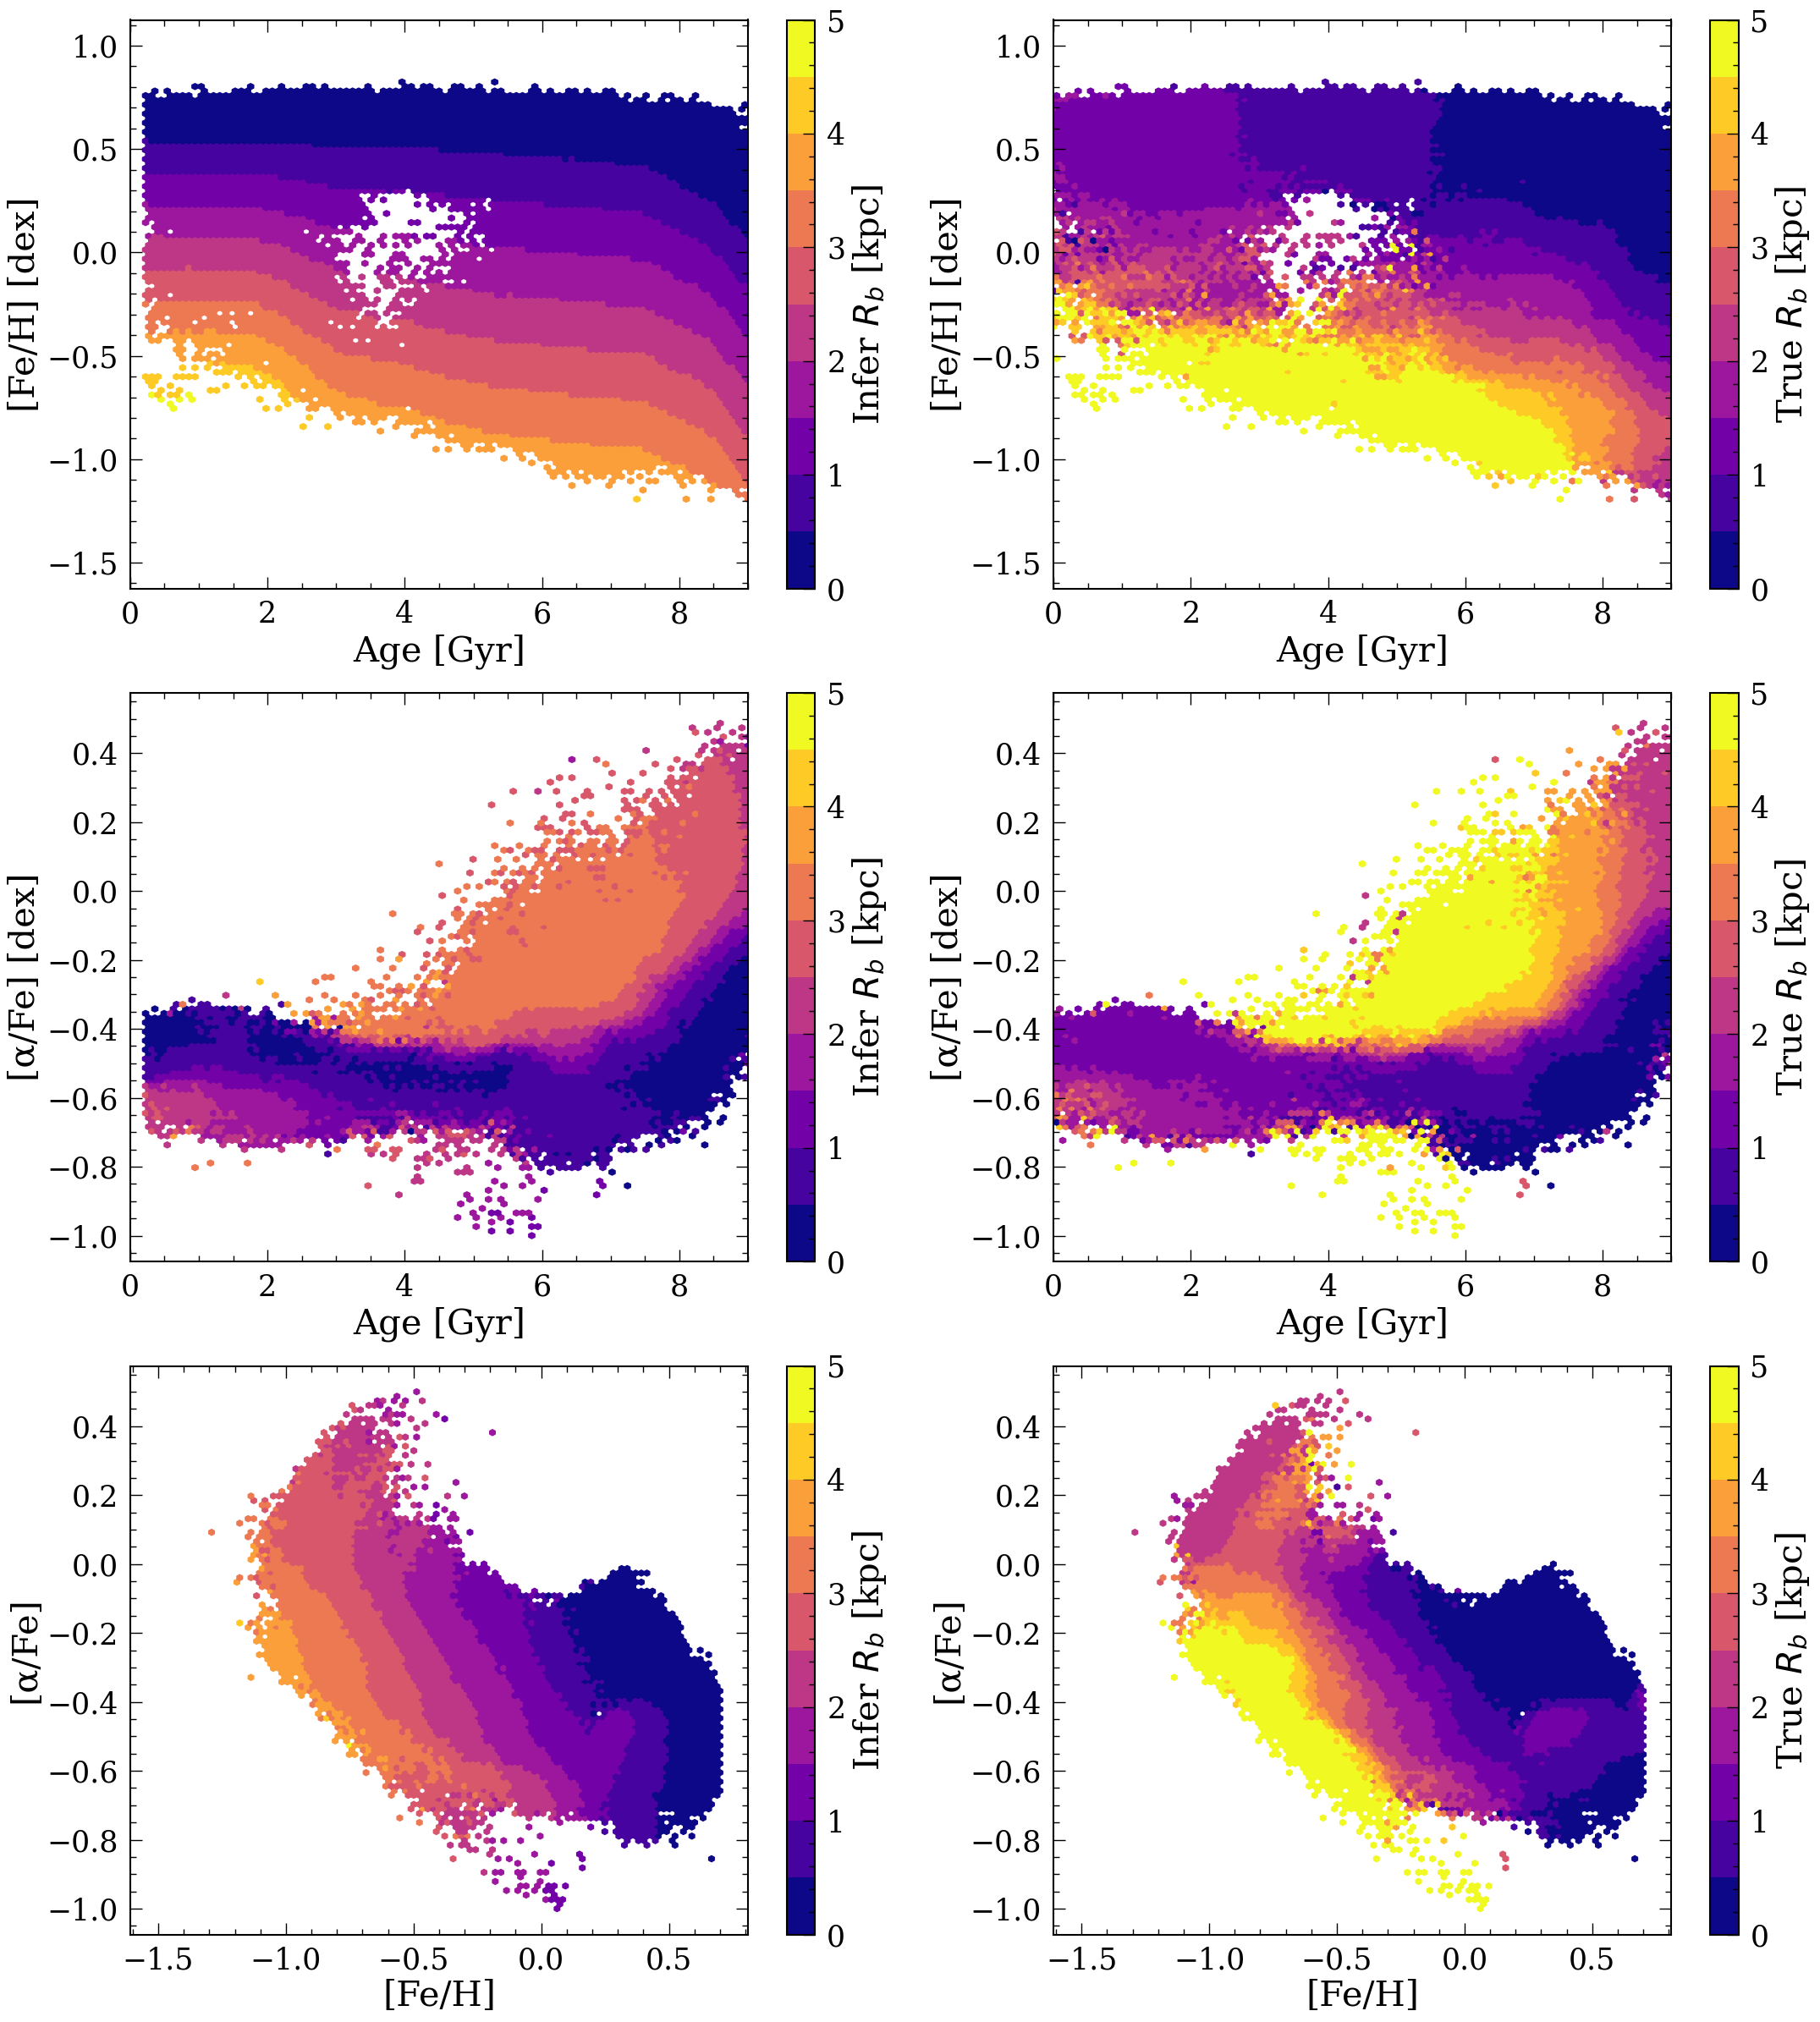

In [215]:
plt.figure(figsize=(22,24))
plt.subplot(3,2,1)
plt.hexbin(data['age_new'],data['feh_new'],C=data['Rb_inf_new'],
          cmap=plt.get_cmap('plasma',10),vmin=0,vmax=5,extent=(0,disktime,-1.5,1))
plt.colorbar(label='Infer $R_b$ [kpc]')
plt.xlabel('Age [Gyr]')
plt.ylabel('[Fe/H] [dex]')
plt.xlim([0,disktime])

plt.subplot(3,2,2)
plt.hexbin(data['age_new'],data['feh_new'],C=data['R_bir'],
          cmap=plt.get_cmap('plasma',10),vmin=0,vmax=5,extent=(0,disktime,-1.5,1))
plt.colorbar(label='True $R_b$ [kpc]')
plt.xlabel('Age [Gyr]')
plt.ylabel('[Fe/H] [dex]')
plt.xlim([0,disktime])

plt.subplot(3,2,3)
plt.hexbin(data['age_new'],data['ofe_new'],C=data['Rb_inf_new'],
          cmap=plt.get_cmap('plasma',10),vmin=0,vmax=5,extent=(0,disktime,-1,0.5))
plt.colorbar(label='Infer $R_b$ [kpc]')
plt.xlabel('Age [Gyr]')
plt.ylabel('[α/Fe] [dex]')
plt.xlim([0,disktime])

plt.subplot(3,2,4)
plt.hexbin(data['age_new'],data['ofe_new'],C=data['R_bir'],
          cmap=plt.get_cmap('plasma',10),vmin=0,vmax=5,extent=(0,disktime,-1,0.5))
plt.colorbar(label='True $R_b$ [kpc]')
plt.xlabel('Age [Gyr]')
plt.ylabel('[α/Fe] [dex]')
plt.xlim([0,disktime])


plt.subplot(3,2,5)
plt.hexbin(data['feh_new'], data['ofe_new'],C=data['Rb_inf_new'],
          cmap=plt.get_cmap('plasma',10),vmin=0,vmax=5,extent=(-1.5,0.7,-1,0.5))
plt.colorbar(label='Infer $R_b$ [kpc]')
plt.ylabel('[α/Fe]')
plt.xlabel('[Fe/H]')
#plt.xlim([0,disktime])

plt.subplot(3,2,6)
plt.hexbin(data['feh_new'], data['ofe_new'],C=data['R_bir'],
          cmap=plt.get_cmap('plasma',10),vmin=0,vmax=5,extent=(-1.5,0.7,-1,0.5))
plt.colorbar(label='True $R_b$ [kpc]')
plt.ylabel('[α/Fe]')
plt.xlabel('[Fe/H]')
#plt.xlim([0,0.5])

plt.tight_layout()

(0.0, 9.0)

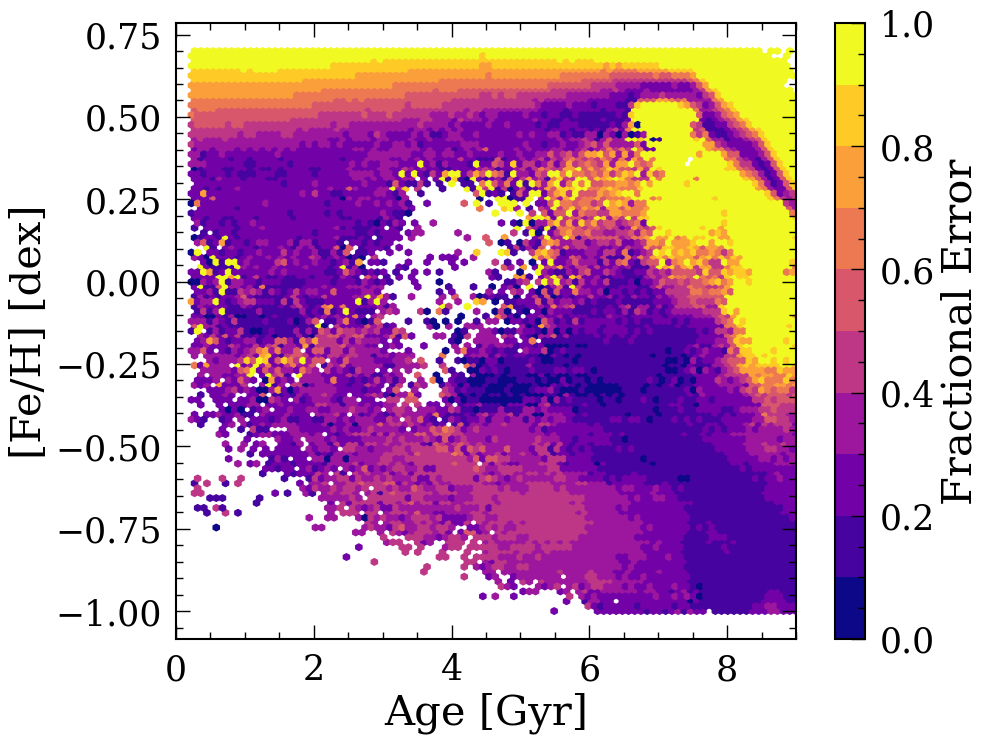

In [216]:
plt.figure(figsize=(10,8))
plt.hexbin(data['age_new'],data['feh_new'],C=abs(data['Rb_inf_new']-data['R_bir'])/data['R_bir'],
          cmap=plt.get_cmap('plasma',10),vmin=0,vmax=1,extent=(0,disktime,-1,0.7),
          reduce_C_function=np.median)
plt.colorbar(label='Fractional Error')
plt.xlabel('Age [Gyr]')
plt.ylabel('[Fe/H] [dex]')
plt.xlim([0,disktime])

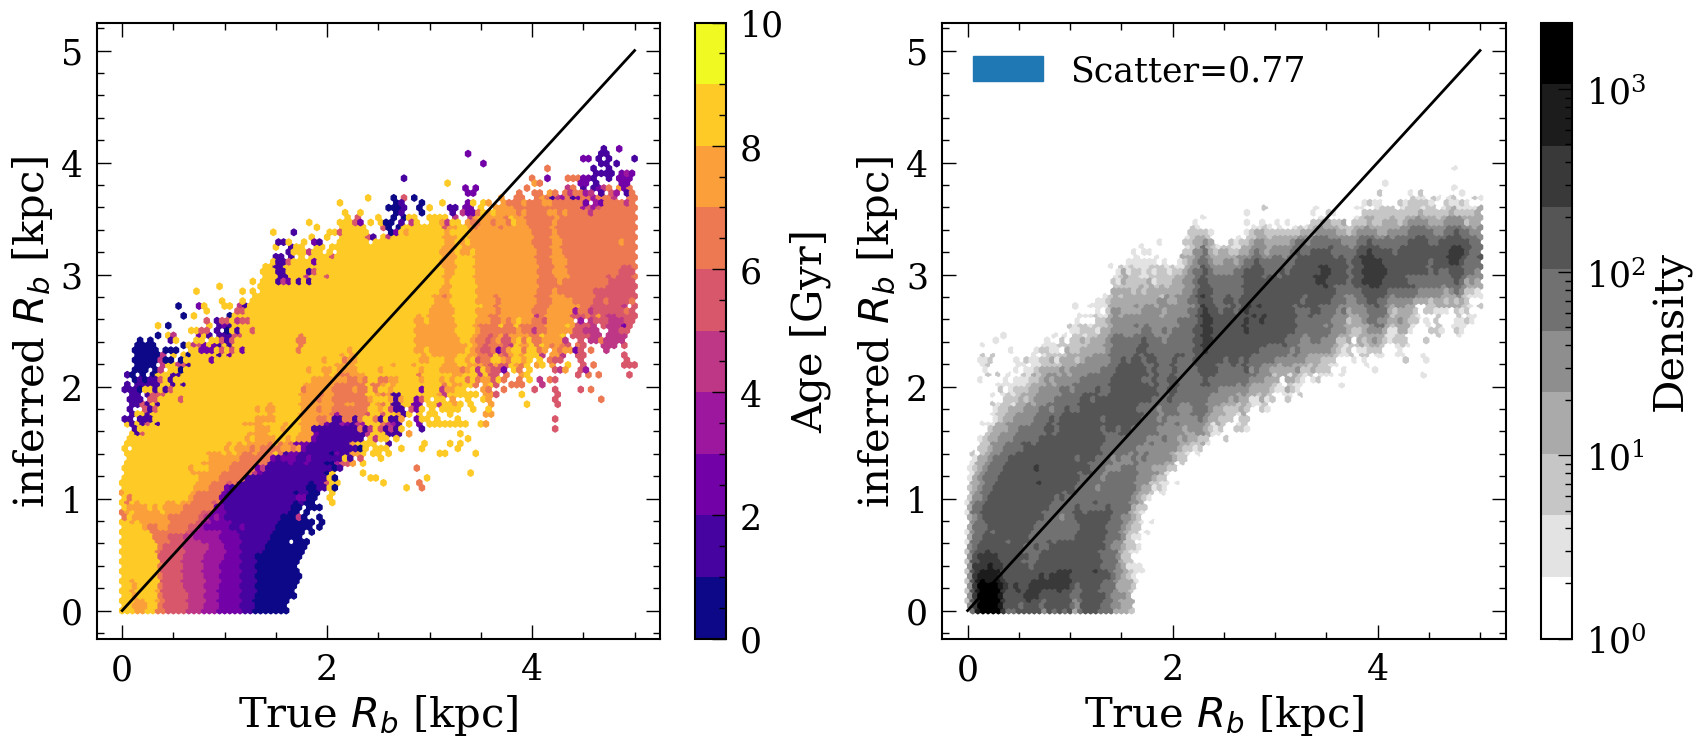

In [217]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.hexbin(data['R_bir'],data['Rb_inf_new'],C=abs(data['age']),
          cmap=plt.get_cmap('plasma',10),vmin=0,vmax=10,extent=(0,5,0,5),
          reduce_C_function=np.median)
plt.colorbar(label='Age [Gyr]')
plt.xlabel('True $R_b$ [kpc]')
plt.ylabel('inferred $R_b$ [kpc]')
plt.plot([0,5],[0,5],'k-')


plt.subplot(1,2,2)
plt.hexbin(data['R_bir'],data['Rb_inf_new'],bins='log',
          cmap=plt.get_cmap('binary',10),extent=(0,5,0,5),
          reduce_C_function=np.median,
           label='Scatter=%.2f'%(np.std(data['R_bir']-data['Rb_inf_new'])))
plt.colorbar(label='Density')
plt.xlabel('True $R_b$ [kpc]')
plt.ylabel('inferred $R_b$ [kpc]')
plt.plot([0,5],[0,5],'k-')
plt.legend()

